<a href="https://colab.research.google.com/github/arizky012/Deep-Learning/blob/master/Resnet_Tomato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls
%cd ./drive/My\ Drive

drive  sample_data
/content/drive/My Drive


In [0]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.applications.resnet import ResNet152

In [0]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
directory_root = './plantvillage-tomato-leaf-dataset/plantvillage/'
width=224
height=224
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite ...
[INFO] Processing Tomato___Tomato_mosaic_virus ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Image loading completed


In [0]:
image_size = len(image_list)

In [8]:
print(image_size)

1999


In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [10]:
print(label_binarizer.classes_)

['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']


In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [12]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [27]:
input_shape = (height, width, depth)

restnet = ResNet152(include_top=False, weights='imagenet', input_shape=(height,width,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output=output)

for layer in restnet.layers:
    layer.trainable = False
  
model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  


In [28]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Model)              (None, 100352)            58370944  
_________________________________________________________________
dense_8 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                5130      
Total params: 110,019,466
Trainable params: 51,648,522
Non-trainable params: 58,370,944
________________________________

In [29]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [30]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/50
49/49 [==============================] - 43s 886ms/step - loss: 2.5051 - acc: 0.8277 - val_loss: 2.8935 - val_acc: 0.8195
Epoch 2/50
49/49 [==============================] - 20s 411ms/step - loss: 2.8825 - acc: 0.8202 - val_loss: 2.8935 - val_acc: 0.8195
Epoch 3/50
49/49 [==============================] - 20s 405ms/step - loss: 2.8765 - acc: 0.8206 - val_loss: 2.8935 - val_acc: 0.8195
Epoch 4/50
49/49 [==============================] - 19s 394ms/step - loss: 2.8828 - acc: 0.8202 - val_loss: 2.8935 - val_acc: 0.8195
Epoch 5/50
49/49 [==============================] - 19s 394ms/step - loss: 2.8847 - acc: 0.8200 - val_loss: 2.8935 - val_acc: 0.8195
Epoch 6/50
49/49 [==============================] - 19s 387ms/step - loss: 2.8951 - acc: 0.8194 - val_loss: 2.8935 - val_acc: 0.8195
Epoch 7/50
49/49 [==============================] - 19s 385ms/step - loss: 2.8806 - acc: 0.8203 - val_loss: 2.8935 - val_acc: 0.8195
Epoch 8/50
49/49 [==============================] - 19s 381ms/step - 

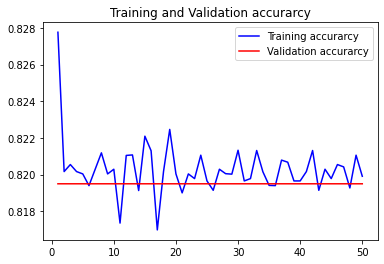

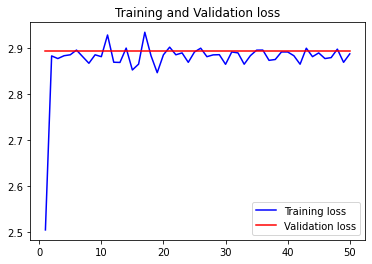

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [31]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
400/400 [==============================] - 2s 6ms/step
Test Accuracy: 81.95000171661377
